In [8]:
# Generate synthetic XOR data that fails most federated learning models

import numpy as np

Ng = 100
Nf = 1000
N1 = np.arange(0,100)
N2 = np.arange(100,200)
mag = 1
N1mag = mag
N2mag = mag
y1 = np.zeros(Ng).astype("long")
y2 = np.zeros(Ng).astype("long")

x1 = np.random.normal(size=(Ng, Nf))
x2 = np.random.normal(size=(Ng, Nf))

for i in range(Ng):
    x1[i,N1] += N1mag
    x2[i,N1] -= N1mag
    if i < 50:
        x1[i,N2] += N2mag
        x2[i,N2] -= N2mag
        y1[i] = 1
        y2[i] = 1
    else:
        x1[i,N2] -= N2mag
        x2[i,N2] += N2mag
        y1[i] = 0
        y2[i] = 0

In [300]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x1tr, x1t, y1tr, y1t, x2tr, x2t, y2tr, y2t = train_test_split(x1, y1, x2, y2, train_size=0.5)

reg = LogisticRegression().fit(x1tr, y1tr)
yhat = reg.predict(x1t)
print(np.sum(yhat == y1t)/len(y1t))

xctr = np.concatenate([x1tr, x2tr])
xct = np.concatenate([x1t, x2t])
yctr = np.concatenate([y1tr, y2tr])
yct = np.concatenate([y1t, y2t])

reg = LogisticRegression().fit(xctr, yctr)
yhat = reg.predict(xct)
print(np.sum(yhat == yct)/len(yct))

0.72
0.47


In [301]:
# Nonlinear supervised global model to solve XOR

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1000, 10).float().cuda()
        self.fc2 = nn.Linear(10, 2).float().cuda()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

mlp = MLP()
ce = nn.CrossEntropyLoss()
optim = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1e-4)

txtr = torch.from_numpy(xctr).float().cuda()
txt = torch.from_numpy(xct).float().cuda()
tytr = torch.from_numpy(yctr).long().cuda()
# tyt = torch.from_numpy(yct).long().cuda()

pperiod = 100
nepochs = 2000

for e in range(nepochs):
    optim.zero_grad()
    yhat = mlp(txtr)
    loss = ce(yhat, tytr)
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')

with torch.no_grad():
    yhat = mlp(txt)
    yhat = torch.argmax(yhat, dim=1)
    yhat = yhat.detach().cpu().numpy()
    print(np.sum(yhat == yct)/len(yct))

0 0.7078756093978882
100 0.27616220712661743
200 0.13646061718463898
300 0.07571619749069214
400 0.04693329334259033
500 0.03228812292218208
600 0.02408512867987156
700 0.019012069329619408
800 0.01567232422530651
900 0.01338448841124773
1000 0.011743413284420967
1100 0.010525673627853394
1200 0.009582462720572948
1300 0.008830379694700241
1400 0.00822683796286583
1500 0.007739505264908075
1600 0.007339651696383953
1700 0.007005344144999981
1800 0.006720703095197678
1900 0.006474481895565987
1999 0.00625943299382925
0.5


In [302]:
# Federated learning on hard synthetic data

xtrs = [
    torch.from_numpy(x1tr).float().cuda(),
    torch.from_numpy(x2tr).float().cuda()
]
ytrs = [
    torch.from_numpy(y1tr).long().cuda(),
    torch.from_numpy(y2tr).long().cuda(),
]
xts = [
    torch.from_numpy(x1t).float().cuda(),
    torch.from_numpy(x2t).float().cuda()
]
yts = [y1t, y2t]
models = [
    MLP(),
    MLP()
]
optims = [
    torch.optim.Adam(models[0].parameters(), lr=1e-4, weight_decay=1e-4),
    torch.optim.Adam(models[1].parameters(), lr=1e-4, weight_decay=1e-4)
]

nepochs = 1000
cperiod = 50

for e in range(nepochs):
    for i in range(len(xtrs)):
        model = models[i]
        optim = optims[i]
        xtr = xtrs[i]
        ytr = ytrs[i]
        optim.zero_grad()
        yhat = model(xtr)
        loss = ce(yhat, ytr)
        loss.backward()
        optim.step()
        if e % cperiod == 0 or e == nepochs-1:
            print(f'{e} {i} {float(loss)}')
            # Combine models
            fc1w = torch.randn(models[0].fc1.weight.shape).float().cuda()*0.0
            fc1b = torch.randn(models[0].fc1.bias.shape).float().cuda()*0.0
            fc2w = torch.randn(models[0].fc2.weight.shape).float().cuda()*0.0
            fc2b = torch.randn(models[0].fc2.bias.shape).float().cuda()*0.0
            with torch.no_grad():
                for model in models:
                    fc1w += model.fc1.weight
                    fc1b += model.fc1.bias
                    fc2w += model.fc2.weight
                    fc2b += model.fc2.bias
                # for model in models:
                #     model.fc1.weight.data = fc1w/len(models)
                #     model.fc1.bias.data = fc1b/len(models)
                #     model.fc2.weight.data = fc2w/len(models)
                #     model.fc2.bias.data = fc2b/len(models)

with torch.no_grad():
    for i in range(len(models)):
        yhat = models[i](xts[i])
        yhat = torch.argmax(yhat, dim=1)
        yhat = yhat.detach().cpu().numpy()
        print(np.sum(yhat == yts[i])/len(yts[i]))
    for model in models:
        model.fc1.weight.data = fc1w/len(models)
        model.fc1.bias.data = fc1b/len(models)
        model.fc2.weight.data = fc2w/len(models)
        model.fc2.bias.data = fc2b/len(models)
    yhat = models[0](txt)
    yhat = torch.argmax(yhat, dim=1)
    yhat = yhat.detach().cpu().numpy()
    print(np.sum(yhat == yct)/len(yct))

0 0 0.6745893359184265
0 1 0.7723416090011597
50 0 0.4136936068534851
50 1 0.428568571805954
100 0 0.30882689356803894
100 1 0.2875588536262512
150 0 0.24441508948802948
150 1 0.21260866522789001
200 0 0.1970069855451584
200 1 0.1557561606168747
250 0 0.15629161894321442
250 1 0.1148901954293251
300 0 0.12320174276828766
300 1 0.08467848598957062
350 0 0.09643693268299103
350 1 0.06876910477876663
400 0 0.07581351697444916
400 1 0.0592922642827034
450 0 0.05899885669350624
450 1 0.05288684740662575
500 0 0.047927502542734146
500 1 0.0484468974173069
550 0 0.04034348577260971
550 1 0.04518956318497658
600 0 0.035029347985982895
600 1 0.03479595109820366
650 0 0.031101079657673836
650 1 0.028150107711553574
700 0 0.028100058436393738
700 1 0.025542786344885826
750 0 0.02575111947953701
750 1 0.02385202795267105
800 0 0.023876667022705078
800 1 0.02259284257888794
850 0 0.02235572040081024
850 1 0.021599112078547478
900 0 0.021104414016008377
900 1 0.020789088681340218
950 0 0.02006192691

In [303]:
from demovae import DemoVAE

vaes = [None, None]

for i in range(2):
    fc = x1tr if i == 0 else x2tr
    demo = [y1tr] if i == 0 else [y2tr]
    demo_types = ['categorical']
    vaes[i] = DemoVAE(pperiod=100, use_cuda=True, nepochs=1000, latent_dim=10, weight_decay=0, lr=5e-5, loss_rec_mult=500, loss_pred_mult=.01)
    vaes[i].fit(fc, demo, demo_types)

Fitting auxilliary guidance model for demographic 0 categorical... done
Converting input to pytorch
Converting demographics to pytorch
Beginning VAE training
Epoch 0 ReconLoss 1.0082 CovarianceLoss 15.0114 MeanLoss 0.1192 DecorLoss 1.3371 GuidanceTargets [0, 1] GuidanceLosses ['1.1635', '1.1635'] 
Epoch 100 ReconLoss 0.851 CovarianceLoss 3.6648 MeanLoss 0.2697 DecorLoss 0.0003 GuidanceTargets [0, 1] GuidanceLosses ['0.0037', '0.0037'] 
Epoch 200 ReconLoss 0.666 CovarianceLoss 15.9689 MeanLoss 0.1131 DecorLoss 0.0002 GuidanceTargets [0, 1] GuidanceLosses ['0.0001', '0.0001'] 
Epoch 300 ReconLoss 0.4172 CovarianceLoss 43.893 MeanLoss 0.0862 DecorLoss 0.0043 GuidanceTargets [0, 1] GuidanceLosses ['0.0', '0.0'] 
Epoch 400 ReconLoss 0.153 CovarianceLoss 64.6531 MeanLoss 0.0875 DecorLoss 0.0138 GuidanceTargets [1, 0] GuidanceLosses ['0.0', '0.0'] 
Epoch 500 ReconLoss 0.0056 CovarianceLoss 61.1164 MeanLoss 0.076 DecorLoss 0.0185 GuidanceTargets [0, 1] GuidanceLosses ['0.0', '0.0'] 
Epoch 600 

In [304]:
N = 1000
xs = [None, None]
ys = np.concatenate([np.zeros(int(N/2)), np.ones(int(N/2))])
demo_types = ['categorical']

for i in range(2):
    xs[i] = vaes[i].transform(N, [ys], demo_types)

xsall = np.concatenate(xs)
ysall = np.concatenate([ys, ys])

reg = LogisticRegression().fit(xsall, ysall)
yhat = reg.predict(xct)
print(np.sum(yhat == yct)/len(yct))

0.53


In [305]:
mlp = MLP()
ce = nn.CrossEntropyLoss()
optim = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1e-4)

txtr = torch.from_numpy(xsall).float().cuda()
txt = torch.from_numpy(xct).float().cuda()
tytr = torch.from_numpy(ysall).long().cuda()
# tyt = torch.from_numpy(yct).long().cuda()

pperiod = 100
nepochs = 2000

for e in range(nepochs):
    optim.zero_grad()
    yhat = mlp(txtr)
    loss = ce(yhat, tytr)
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')

with torch.no_grad():
    yhat = mlp(txt)
    yhat = torch.argmax(yhat, dim=1)
    yhat = yhat.detach().cpu().numpy()
    print(np.sum(yhat == yct)/len(yct))

0 0.6901477575302124
100 0.22021877765655518
200 0.08817043900489807
300 0.0460381880402565
400 0.028111746534705162
500 0.018908748403191566
600 0.013566943816840649
700 0.010196353308856487
800 0.0079348711296916
900 0.006343821994960308
1000 0.005181894637644291
1100 0.004307610914111137
1200 0.0036332341842353344
1300 0.0031022499315440655
1400 0.0026768064126372337
1500 0.002330734161660075
1600 0.0020455000922083855
1700 0.0018077086424455047
1800 0.0016074650920927525
1900 0.0014373381854966283
1999 0.0012929871445521712
0.51


/tmp/ipykernel_71171/2350575515.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


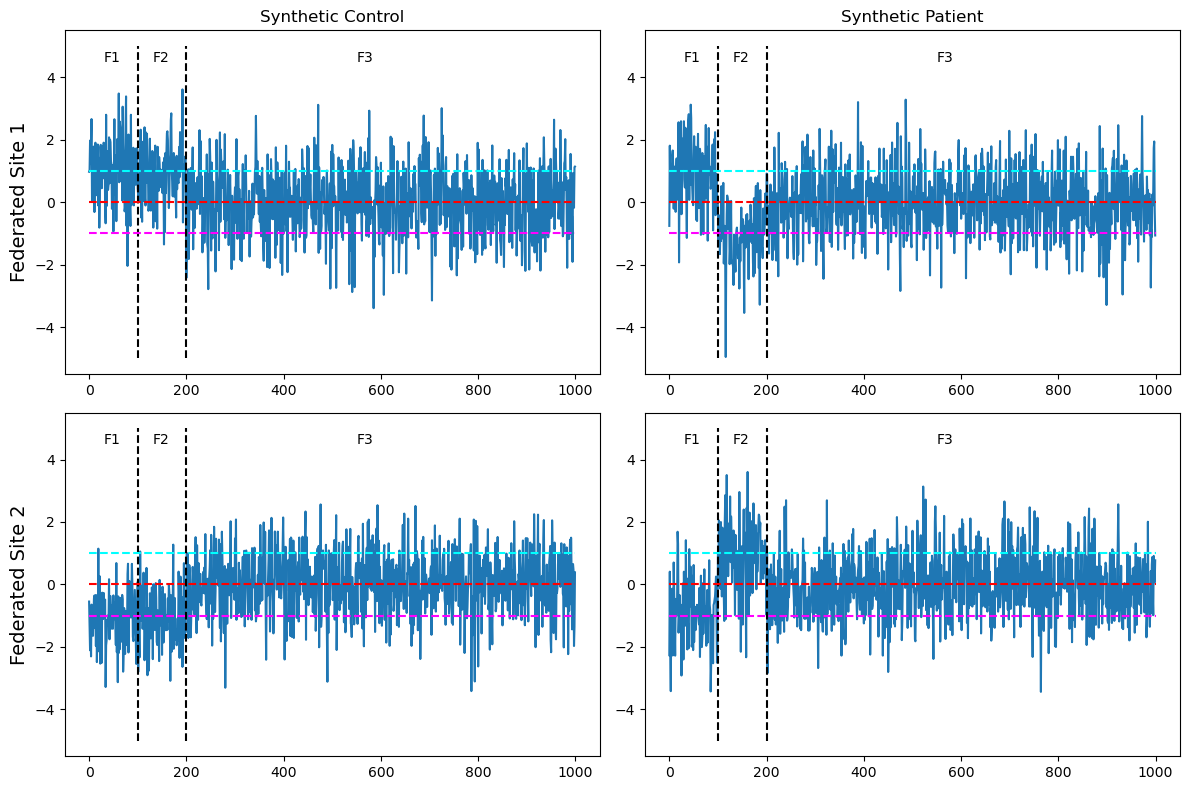

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2,figsize=(12,8))

ax[0,0].plot(x1[0])
ax[0,1].plot(x1[50])
ax[1,0].plot(x2[9])
ax[1,1].plot(x2[50])

for i in range(2):
    for j in range(2):
        ax[i,j].plot([100,100],[-5,5],linestyle='--', color='black')
        ax[i,j].plot([200,200],[-5,5],linestyle='--', color='black')
        ax[i,j].plot([0,1000],[0,0],linestyle='--',color='red')
        ax[i,j].plot([0,1000],[1,1],linestyle='--',color='cyan')
        ax[i,j].plot([0,1000],[-1,-1],linestyle='--',color='magenta')
        ax[i,j].text(30,4.5,"F1")
        ax[i,j].text(130,4.5,"F2")
        ax[i,j].text(550,4.5,"F3")

ax[0,0].set_ylabel('Federated Site 1', fontsize=14)
ax[1,0].set_ylabel('Federated Site 2', fontsize=14)
ax[0,0].set_title('Synthetic Control')
ax[0,1].set_title('Synthetic Patient')

fig.tight_layout()
fig.savefig('/home/anton/Documents/Tulane/Research/FederatedVAE/Figures/synth-data.pdf')
fig.show()

/tmp/ipykernel_71171/3720533242.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


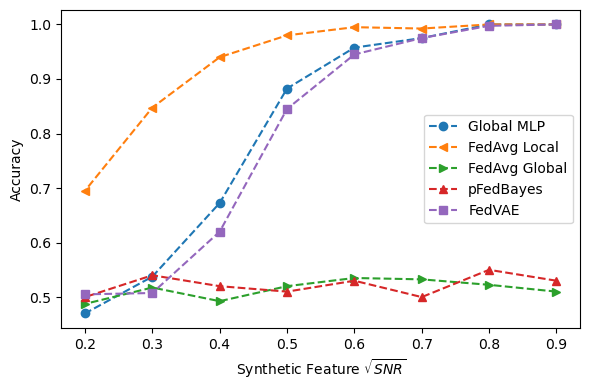

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4))

mlp = [1, 1,	0.975,	0.9575,	0.8825,	0.6725,	0.5375,	0.47]
fedlocal = [1, 1,	0.9925,	0.995,	0.98,	0.94,	0.8475,	0.695]
fedglob = [0.51, 0.5225,	0.5325,	0.535,	0.52,	0.4925,	0.5175,	0.4875]
pfedbayes = [0.53, 0.55,	0.5,	0.53,	0.51,	0.52,	0.54,	0.5]
fedvae = [1, 0.9975,	0.975,	0.945,	0.845,	0.62,	0.5075,	0.505]

snr = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

ax.plot(snr, mlp, linestyle='--', marker='o', label='Global MLP')
ax.plot(snr, fedlocal, linestyle='--', marker='<', label='FedAvg Local')
ax.plot(snr, fedglob, linestyle='--', marker='>', label='FedAvg Global')
ax.plot(snr, pfedbayes, linestyle='--', marker='^', label='pFedBayes')
ax.plot(snr, fedvae, linestyle='--', marker='s', label='FedVAE')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Synthetic Feature $\\sqrt{SNR}$')
ax.legend()

fig.tight_layout()
fig.savefig('/home/anton/Documents/Tulane/Research/FederatedVAE/Figures/synth-acc.pdf')
fig.show()